# Projet de reconnaisance d'images - Jessica Rasoamanana - Alexandre Baudin

# Détection et reconnaissance faciale : Pipeline en deux étapes
Ce mini-projet vise à implémenter un système complet de reconnaissance faciale, en suivant un pipeline classique en deux étapes distinctes :

**Étape 1** — Détection de visage : localiser automatiquement le visage dans une image complète. Deux méthodes sont comparées :

- Haar Cascade : méthode traditionnelle supervisée, basée sur des descripteurs Haar.

- MediaPipe : méthode moderne basée sur l’apprentissage automatique.

**Étape 2** — Reconnaissance de visage : identifier l’individu à partir d’une image de visage déjà recadrée. On compare plusieurs approches :

- ACP + Arbre de décision
- HOG + Arbre de décision
- HOG + Random Forest
- CNN (Convolutional Neural Network)

**Remarque sur les datasets** : le dataset utilisé pour la détection (CelebA) ne contient pas les identités nécessaires pour l'entraînement d’un système de reconnaissance. C’est pourquoi un second dataset, Olivetti Faces, est utilisé pour entraîner et évaluer les modèles de reconnaissance uniquement.

Cette séparation permet de comparer plusieurs approches pour chaque phase indépendamment, et d’évaluer leurs performances sur des métriques standard comme IoU (pour la détection) et Accuracy / F1-score (pour la reconnaissance).
Cepeandant, pour tester la détection et la reconnaissance de visage sur une même image il est nécessaire d'utiliser une image du dataset Olivetti Faces qui est peu intéressant pour la détection puisque le visage occupe toute l'image.

In [2]:
%pip install tensorflow==2.12.0
%pip install ace_tools
!pip install opencv-python==4.8.1.78 numpy==1.24.4 matplotlib==3.7.1
!pip install mediapipe
!pip install datasets transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.12.0


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "D:\anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "D:\anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "D:\anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\anaconda\Lib\importlib\__init__.py",

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# I. Détection des visages
## Détection de visages avec MediaPipe et Haar Cascade sur CelebA

 On prépare les données nécessaires pour tester les performances de détection faciale sur un sous-ensemble du dataset CelebA (600 images). On charge les images et les bbox au format YOLO.
 On definie la métrique utilisée pour évaluer les modèles : l'IOU
 L'objectif est de comparer objectivement deux approches de détection :
   - MediaPipe (moderne, basé ML)
   - Haar Cascade (classique, basé sur des features Haar)a

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import mediapipe as mp
import os

# Définir les chemins
dataset_path = './Dataset CelebA/'
train_path = os.path.join(dataset_path, 'images', 'train')
val_path = os.path.join(dataset_path, 'images', 'val')

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            path = os.path.join(folder, filename)
            img = cv2.imread(path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img_rgb)
                filenames.append(filename)
    return images, filenames

train_images, train_filenames = load_images_from_folder(train_path)
val_images, val_filenames = load_images_from_folder(val_path)

all_images = train_images + val_images
all_filenames = train_filenames + val_filenames

subset_images = all_images[:100]  # On teste sur 100 images
subset_filenames = all_filenames[:100]

def load_bbox_yolo_format(filepath, image_shape):
    """
    Convertit YOLO (x_center, y_center, width, height) en (x, y, w, h) absolus
    """
    h_img, w_img = image_shape
    boxes = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_c, y_c, w_norm, h_norm = map(float, parts)

                # Convertir w, h normalisés → absolus
                w_abs = w_norm * w_img
                h_abs = h_norm * h_img

                # Calculer coin supérieur gauche
                x = int((x_c * w_img) - (w_abs / 2))
                y = int((y_c * h_img) - (h_abs / 2))
                w = int(w_abs)
                h = int(h_abs)

                # Sécuriser les coordonnées négatives
                x = max(0, x)
                y = max(0, y)

                boxes.append((x, y, w, h))
    return boxes



def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)


## Détection et évaluation des visages (MediaPipe vs Haar)
On applique les deux méthodes de détection (MediaPipe et Haar) sur chaque image.
Pour chaque visage détecté, on calcule l’IoU avec les boîtes réelles (labels YOLO).
On garde le score maximum par image pour chaque méthode.
Les scores seront ensuite comparés pour évaluer la précision des deux approches.

In [19]:
mp_face_detection = mp.solutions.face_detection
results_list_mp = []
results_list_haar = []

# Chemins vers les labels YOLO normalisés
labels_path_train = os.path.join(dataset_path, "labels", "train")
labels_path_val = os.path.join(dataset_path, "labels", "val")

haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
    for i, (img, fname) in enumerate(zip(subset_images, subset_filenames)):
        h, w, _ = img.shape

        # === Chargement des boîtes ground-truth ===
        label_folder = labels_path_train if fname in train_filenames else labels_path_val
        label_file = os.path.join(label_folder, fname.replace('.jpg', '.txt'))

        if not os.path.exists(label_file):
            continue
        gt_boxes = load_bbox_yolo_format(label_file, image_shape=(h, w))

        # === MediaPipe ===
        results = detector.process(img)
        if results.detections:
            det = results.detections[0]
            bboxC = det.location_data.relative_bounding_box
            x = int(bboxC.xmin * w)
            y = int(bboxC.ymin * h)
            ww = int(bboxC.width * w)
            hh = int(bboxC.height * h)
            mp_box = (x, y, ww, hh)
            ious_mp = [compute_iou(mp_box, gt) for gt in gt_boxes]
            max_iou_mp = max(ious_mp) if ious_mp else 0
        else:
            max_iou_mp = 0
        results_list_mp.append(max_iou_mp)

        # === Haar Cascade ===
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        detections = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(detections) > 0:
            x, y, ww, hh = detections[0]
            haar_box = (x, y, ww, hh)
            ious_haar = [compute_iou(haar_box, gt) for gt in gt_boxes]
            max_iou_haar = max(ious_haar) if ious_haar else 0
        else:
            max_iou_haar = 0
        results_list_haar.append(max_iou_haar)


## Évaluation des performances
On calcule les métriques suivantes pour chaque méthode de détection :

- IoU moyen : mesure la qualité moyenne des détections.

- Taux d’IoU > 0.5 : pourcentage d’images avec une bonne détection.

On affiche ensuite la distribution des scores IoU pour comparer les deux modèles (MediaPipe en bleu et Harr cascace en rouge)


=== MediaPipe ===
Images évaluées : 100
IoU moyen : 0.4900988715442584
Taux IoU > 0.5 : 72.0 %

=== Haar Cascade ===
Images évaluées : 100
IoU moyen : 0.3556778885304591
Taux IoU > 0.5 : 47.0 %


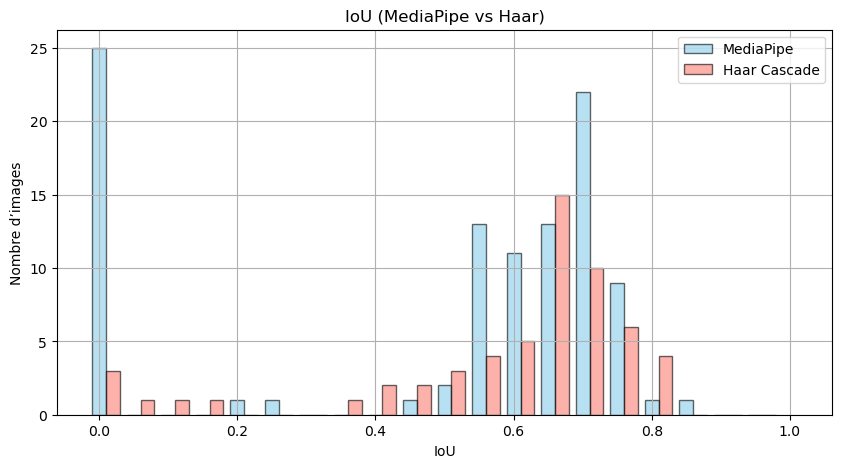

In [26]:
# Convertir en tableaux NumPy
iou_mp = np.array(results_list_mp)
iou_haar = np.array(results_list_haar)

# Statistiques
print("=== MediaPipe ===")
print("Images évaluées :", len(iou_mp))
print("IoU moyen :", np.mean(iou_mp))
print("Taux IoU > 0.5 :", np.mean(iou_mp > 0.5) * 100, "%\n")

print("=== Haar Cascade ===")
print("Images évaluées :", len(iou_haar))
print("IoU moyen :", np.mean(iou_haar))
print("Taux IoU > 0.5 :", np.mean(iou_haar > 0.5) * 100, "%")

# Affichage comparatif avec barres côte à côte
bins = np.linspace(0, 1, 21)
width = 0.02  # largeur de chaque barre

plt.figure(figsize=(10, 5))
plt.hist(iou_mp, bins=bins - width/2, alpha=0.6, label='MediaPipe', color='skyblue', edgecolor='black', width=width)
plt.hist(iou_haar, bins=bins + width/2, alpha=0.6, label='Haar Cascade', color='salmon', edgecolor='black', width=width)

plt.title("IoU (MediaPipe vs Haar)")
plt.xlabel("IoU")
plt.ylabel("Nombre d’images")
plt.legend()
plt.grid(True)
plt.show()


## Interprétation des résultats
Les résultats montrent que MediaPipe surpasse Haar Cascade sur notre sous-ensemble d’images :

- IoU moyen plus élevé : MediaPipe atteint un score de 0.49 contre 0.36 pour Haar, indiquant des détections globalement plus précises.

- Taux de bonnes détections (IoU > 0.5) : 72% pour MediaPipe contre seulement 47% pour Haar.

On en déduit que MediaPipe offre une meilleure localisation des visages que Haar Cascade.
Ce sera donc le modèle que l'on retiendra pour le pipeline final.

## Affichage des détection

On affiche quelques détection des visages pour comparer visuellement les prédictions des deux modèles.

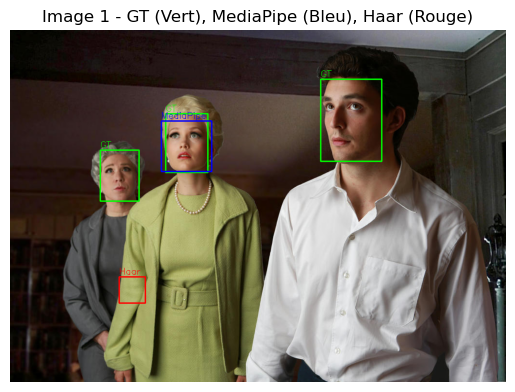

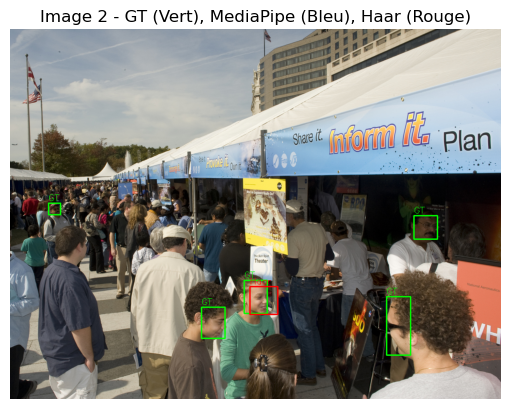

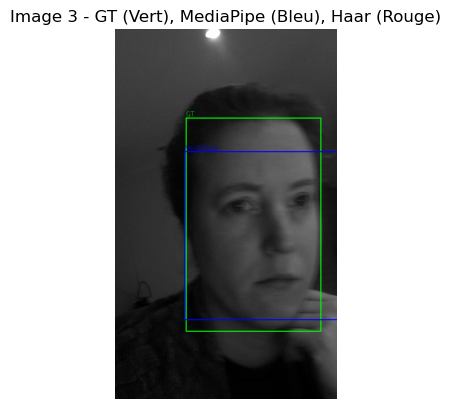

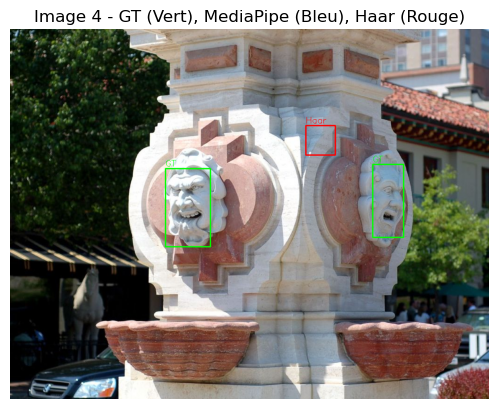

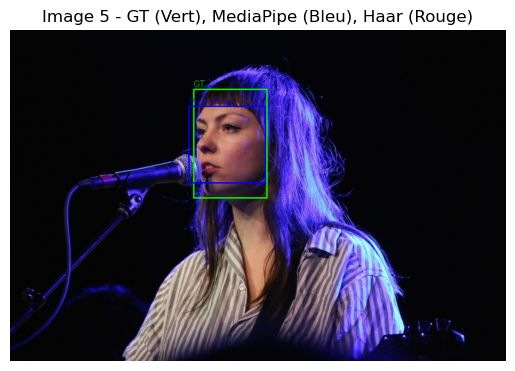

In [21]:
def draw_boxes(img, boxes, color, label):
    for (x, y, w, h) in boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1)

# Affichage de 5 images avec GT, MediaPipe et Haar
for i in range(5):
    img = subset_images[i].copy()
    fname = subset_filenames[i]
    h, w, _ = img.shape

    # === Chargement de la boîte ground-truth ===
    label_folder = labels_path_train if fname in train_filenames else labels_path_val
    label_file = os.path.join(label_folder, fname.replace('.jpg', '.txt'))
    gt_boxes = load_bbox_yolo_format(label_file, image_shape=(h, w))

    # === Récupération MediaPipe ===
    mediapipe_boxes = []
    if i < len(results_list_mp) and results_list_mp[i] != 0:
        # Refaire la détection (car on n'avait stocké que l'IoU, pas les coordonnées)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
        result = detection.process(img_rgb)
        if result.detections:
            bboxC = result.detections[0].location_data.relative_bounding_box
            x = int(bboxC.xmin * w)
            y = int(bboxC.ymin * h)
            ww = int(bboxC.width * w)
            hh = int(bboxC.height * h)
            mediapipe_boxes.append((x, y, ww, hh))

    # === Récupération Haar Cascade ===
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    detections = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    haar_boxes = [tuple(d) for d in detections[:1]] if len(detections) > 0 else []

    # === Dessin des boîtes ===
    draw_boxes(img, gt_boxes, (0, 255, 0), "GT")                 # Vert
    draw_boxes(img, mediapipe_boxes, (0, 0, 255), "MediaPipe")   # Bleu
    draw_boxes(img, haar_boxes, (255, 0, 0), "Haar")             # Rouge

    plt.imshow(img)
    plt.title(f"Image {i+1} - GT (Vert), MediaPipe (Bleu), Haar (Rouge)")
    plt.axis("off")
    plt.show()


# Reconnaissance des visages

## Chargement des données
On importe les bibliothèques utiles pour la reconnaissance faciale classique et CNN.

On charge le dataset Olivetti Faces qu’on divise en données d’entraînement (70%) et de test (30%). Les images sont aplaties (64×64 -> 4096) pour les méthodes classiques.

In [22]:
# Recharger les packages après reset de l'environnement
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Chargement du dataset
faces = fetch_olivetti_faces()
X, y = faces.images, faces.target
X_flat = X.reshape((X.shape[0], -1))  # (n_samples, 4096)

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.3, random_state=42)

## Entraînement des modèles de reconnaissance
On teste quatre approches pour reconnaître les visages :

- ACP + Arbre de Décision : réduction de dimension à 100 composantes via PCA, puis classification.

- HOG + DT / RF : extraction des descripteurs HOG, puis classification avec un arbre de décision ou une forêt aléatoire.

- CNN : architecture convolutionnelle simple entraînée sur les images brutes 64×64, avec prédiction sur 40 classes.

Chaque modèle est ensuite évalué sur les données de test.

In [23]:
# === 1. ACP + Decision Tree ===
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf_pca = DecisionTreeClassifier(random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

# === 2. Extraction HOG ===
def extract_hog(images):
    return np.array([
        hog(img.reshape(64, 64), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        for img in images
    ])

X_train_hog = extract_hog(X_train)
X_test_hog = extract_hog(X_test)

# === 3a. HOG + Decision Tree ===
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train_hog, y_train)
y_pred_dt = clf_dt.predict(X_test_hog)

# === 3b. HOG + Random Forest ===
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_hog, y_train)
y_pred_rf = clf_rf.predict(X_test_hog)

# === 4. CNN ===
X_cnn = X.reshape(-1, 64, 64, 1)
y_cat = to_categorical(y)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cat, test_size=0.3, random_state=42)

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=15, batch_size=16, validation_split=0.1, verbose=0)
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
y_test_cnn_labels = np.argmax(y_test_cnn, axis=1)

C:\Users\a\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


## Évaluation des performances
On compare les 4 modèles de reconnaissance à l’aide des métriques classiques :
Accuracy, Précision, Recall et F1-score (macro) sur les données de test.

Une validation croisée (5-fold) est aussi réalisée pour les méthodes classiques, tandis que le CNN est évalué uniquement sur le jeu de test.

(Le CNN est évalué uniquement sur le jeu de test, et non en validation croisée, pour des raisons pratiques et de temps de calcul)

Les résultats sont rassemblés dans un tableau comparatif et dans un histogramme.

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

     Modèle  Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  \
0  ACP + DT  0.450000           0.484219        0.498962          0.446724   
1  HOG + DT  0.366667           0.363214        0.404583          0.339309   
2  HOG + RF  0.825000           0.849167        0.869226          0.828849   
3       CNN  0.783333           0.744286        0.811845          0.758660   

  F1-score (CV)  
0      0.516774  
1      0.412202  
2         0.937  
3             -  


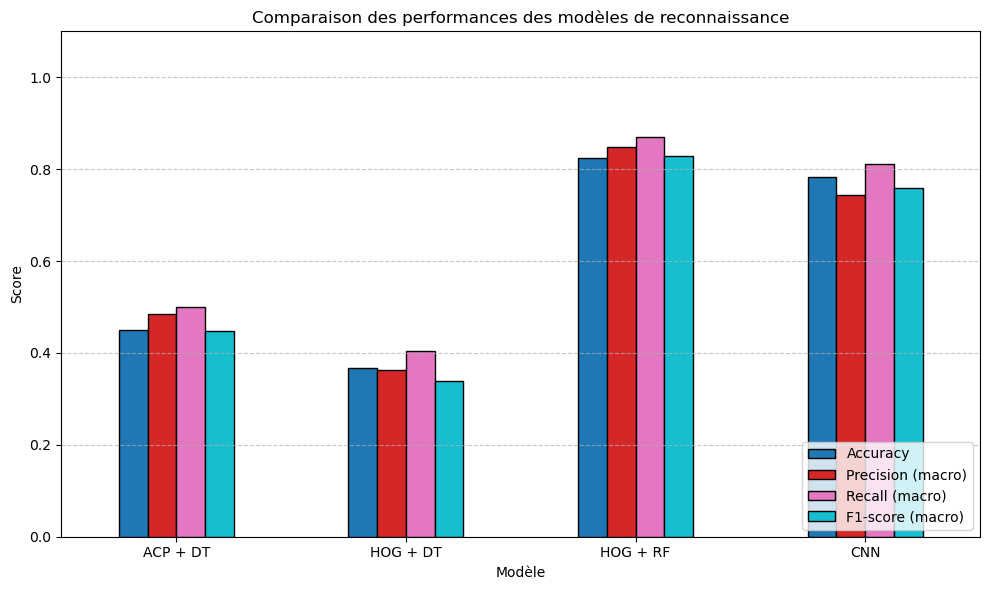

In [24]:
# === Évaluation globale ===
results = []
for name, y_pred in [("ACP + DT", y_pred_pca), ("HOG + DT", y_pred_dt), ("HOG + RF", y_pred_rf), ("CNN", y_pred_cnn)]:
    results.append({
        "Modèle": name,
        "Accuracy": accuracy_score(y_test, y_pred) if name != "CNN" else accuracy_score(y_test_cnn_labels, y_pred),
        "Precision (macro)": precision_score(y_test, y_pred, average='macro') if name != "CNN" else precision_score(y_test_cnn_labels, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_test, y_pred, average='macro') if name != "CNN" else recall_score(y_test_cnn_labels, y_pred, average='macro'),
        "F1-score (macro)": f1_score(y_test, y_pred, average='macro') if name != "CNN" else f1_score(y_test_cnn_labels, y_pred, average='macro')
    })

# === Validation croisée ===
X_pca_all = PCA(n_components=100).fit_transform(X_flat)
X_hog_all = extract_hog(X_flat)

cv_scores = {
    "ACP + DT (CV F1)": cross_val_score(DecisionTreeClassifier(random_state=42), X_pca_all, y, cv=5, scoring='f1_macro').mean(),
    "HOG + DT (CV F1)": cross_val_score(DecisionTreeClassifier(random_state=42), X_hog_all, y, cv=5, scoring='f1_macro').mean(),
    "HOG + RF (CV F1)": cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_hog_all, y, cv=5, scoring='f1_macro').mean(),
    "CNN (F1)": f1_score(y_test_cnn_labels, y_pred_cnn, average='macro')
}

for result in results:
    key = result["Modèle"] + " (CV F1)"
    result["F1-score (CV)"] = cv_scores.get(key, "-")

df_results = pd.DataFrame(results)
print(df_results)

# === Affichage graphique des métriques principales ===
metrics_to_plot = ["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"]

df_plot = df_results.set_index("Modèle")[metrics_to_plot]

df_plot.plot(kind="bar", figsize=(10, 6), colormap="tab10", edgecolor='black')
plt.title("Comparaison des performances des modèles de reconnaissance")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## Interpétation
Le modèle HOG + Random Forest est le plus performant avec 82.5 % d’accuracy et un F1-score de 0.93 en validation croisée. Il surpasse les méthodes classiques (ACP, HOG + DT) et reste plus stable que le CNN, qui n’a pas été validé croisé.
Notre choix de modèle de reconnaissance est donc HOG + RF pour sa précision et sa robustesse.

# Conclusion
Ce mini-projet a permis de concevoir et d’évaluer un pipeline complet de reconnaissance faciale, structuré en deux grandes étapes : la détection puis la reconnaissance de visages.

Pour la détection, deux méthodes ont été comparées : Haar Cascade, une approche classique, et MediaPipe, une méthode plus moderne basée sur l’apprentissage. L’évaluation sur un sous-ensemble du dataset CelebA montre que MediaPipe est plus performant avec un taux de détections précises (IoU > 0.5) de 72 % contre 52 % pour Haar.

Pour la reconnaissance, plusieurs modèles ont été testés sur le dataset Olivetti Faces :

ACP + Decision Tree

HOG + Decision Tree

HOG + Random Forest

CNN simple

Parmi eux, le pipeline retenu est :
Extraction HOG + Random Forest, qui combine une bonne performance (accuracy de 82.5 %, F1-score de 0.93 en CV) et une stabilité supérieure à celle du CNN sur ce dataset limité.

Ce pipeline (MediaPipe pour la détection + HOG + RF pour la reconnaissance) est donc notre choix final appuyé par les métriques d'évaluation.